# p-Kinematic hardening - One-dimensional example

This example gives the numerical implementation of the parallel kinematic hardening model.

For background, see: Houlsby et al. (2017) A model for nonlinear hysteretic and ratcheting behaviour. _International Journal of Solids and Structures_ __120__ 67-80.

The Gibbs free energy $g$ and the yield functions $y_n$ for this model are given by:

\begin{align*}
g = & -\frac{\left( \sigma + \sum_{n=1}^{N} H_n \alpha_n \right)^2}{2E_0} + \frac{1}{2} \sum_{n=1}^N H_n \alpha_n^2\\
y_n = & \left| \chi_n \right|  - k_n 
\end{align*}

The incremental response follows from a standardised approach, which can be written in the following form:

\begin{align*}
-\dot{\epsilon} & = \frac{\partial^2 g}{\partial \sigma^2} \dot{\sigma} + \sum_{n=1}^{N} \frac{\partial^2 g}{\partial \sigma \partial \alpha_n} \dot{\alpha}_n \\
-\dot{\bar{\chi}}_n & = \frac{\partial^2 g}{\partial \sigma \partial \alpha_n} \dot{\sigma} + \sum_{m=1}^{N} \frac{\partial^2 g}{\partial \alpha_m \partial \alpha_n} \dot{\alpha}_n  
\end{align*}

The rate of hardening strain is defined by:

\begin{equation*}
\dot{\alpha}_n = \lambda_n \frac{\partial y_n}{\partial \chi}
\end{equation*}

where the multiplyer $\lambda_n$ is derived from the consistency condition:
\begin{equation*}
\dot{y}_n = 0 = \frac{\partial y_n}{\partial \sigma} \dot{\sigma} + \sum_{m=1}^N \frac{\partial y_n}{\partial \chi_m} \dot{\chi_m} + \sum_{m=1}^N \frac{\partial y_n}{\partial \alpha_m} \dot{\alpha_m} 
\end{equation*}

Combining the above equations for the one dimensional model with Ziegler's orthogonality condition ($\chi_n=\bar{\chi}_n$), and substituting $\frac{\partial y_n}{\partial \chi_m}=0$ for $m \neq n$, gives:
\begin{align*}
0 = & - \frac{\partial y_n}{\partial \chi_n} \left( \frac{\partial^2 g}{\partial \sigma \partial \alpha_n} \dot{\sigma} + \sum_{m=1}^N \frac{\partial^2 g}{\partial \alpha_n \alpha_m} \lambda_m \frac{\partial y_m}{\partial \chi_m} \right) 
\end{align*}

In [1]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
%matplotlib inline
from discretise_kinematic_hardening import discretise_kinematic_hardening_parallel

In [2]:
# The implementation of the above equations is given below

# Model parameters
sigma_backbone = np.array([0.2, 0.4, 0.6, 0.8, 1])
epsilon_backbone = np.array([0.2, 0.6, 1.2, 2.0, 3.0])

k_n, H_n = discretise_kinematic_hardening_parallel(sigma_backbone, epsilon_backbone)
k_n = np.asarray(np.transpose(np.matrix(k_n)))
H_n = np.asarray(np.transpose(np.matrix(H_n)))

E_0 = np.sum(H_n)

# Initialise the model state parameters
epsilon = 0
chi_n = np.zeros_like(H_n)
alpha_n = np.zeros_like(H_n)

# Define the applied stress history
sigma_max_abs_1 = 0.9
sigma_max_abs_2 = 0

d_sigma_abs = 0.002

sigma_loop = np.append(np.arange(0, sigma_max_abs_1, d_sigma_abs), 
                np.arange(sigma_max_abs_1, -sigma_max_abs_2, -d_sigma_abs))

sigma_history = np.tile(sigma_loop, 10)
epsilon_history = np.zeros(len(sigma_history))

d2_g_d_s2 = -1/E_0
d2_g_d_an2 = -np.matmul(H_n, np.transpose(H_n))/(E_0) + np.diag(H_n[:,0])
d2_g_d_san = -np.transpose(H_n) / E_0
d2_g_d_ans = -H_n / E_0

sigma_0 = 0

# Calculate the incremental response
for index, sigma in enumerate(sigma_history):
        
    d_sigma = sigma - sigma_0
            
    y_n = np.abs(chi_n) - k_n
    d_y_n_d_chi_n = np.sign(chi_n)
    
    # Solve A * lambda_n = b
    b = np.zeros_like(H_n)
    A = np.zeros_like(d2_g_d_an2)
    lambda_n = np.zeros_like(H_n)
    for i_y in range(0,len(H_n)):
        b[i_y,0] = - d_y_n_d_chi_n[i_y] * d2_g_d_ans[i_y] * d_sigma
        A[i_y,:] = d_y_n_d_chi_n[i_y] * d2_g_d_an2[i_y,:] * np.transpose(d_y_n_d_chi_n)
        
    y_active = ((y_n>0) * (d_sigma*d_y_n_d_chi_n>0))[:,0]
    if np.sum(y_active) > 0:
        lambda_active = la.solve(A[y_active,:][:,y_active], b[y_active])
        lambda_n[y_active] = lambda_active
                
    d_alpha_n = lambda_n * d_y_n_d_chi_n
        
    d_epsilon = - (d2_g_d_s2 * d_sigma + np.matmul(d2_g_d_san, d_alpha_n))
    d_chi_n = - (d2_g_d_ans * d_sigma + np.matmul(d2_g_d_an2, d_alpha_n))
            
    epsilon = epsilon + d_epsilon
    chi_n = chi_n + d_chi_n
    alpha_n = alpha_n + d_alpha_n
    
    sigma_0 = sigma
            
    epsilon_history[index] = epsilon   

Text(0,0.5,'$\\sigma$')

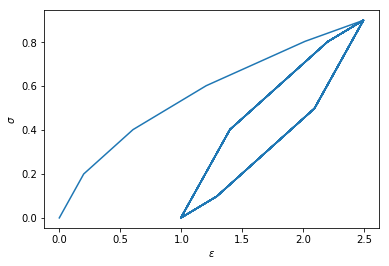

In [3]:
plt.plot(epsilon_history, sigma_history)
plt.xlabel('$\epsilon$')
plt.ylabel('$\sigma$')